In [1]:
#  ingnore settingcopywarning in pandas
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd

raw = pd.read_csv('./data/eemployes_data.csv')

In [2]:
raw.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Target distribution:

In [3]:
raw.loc[:, 'churn'].mean()

0.2380825388359224

Pearson correlation of features with the target:

In [4]:
raw.corr().loc[:, 'churn']

satisfaction           -0.388375
evaluation              0.006567
number_of_projects      0.023787
average_montly_hours    0.071287
time_spend_company      0.144822
work_accident          -0.154622
churn                   1.000000
promotion              -0.061788
Name: churn, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split

import random
seed = random.randint(0, 2^8)
train, test = train_test_split(raw, stratify=raw.loc[:, 'churn'], random_state=seed)

ds = {
    'train': train, 'test': test
}

for name, data in ds.items():
    t = data.loc[:, 'churn'].mean()
    print(f'{name} - {data.shape} - {t} target avg')

#  label encode salary
train.loc[:, 'salary'] = train.loc[:, 'salary'].replace({'high': 2, 'medium': 1, 'low': 0})

#  one-hot department
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
oh = enc.fit_transform(train.loc[:, 'department'].values.reshape(train.shape[0], -1))
train.drop('department', inplace=True, axis=1)
depart = pd.DataFrame(oh.todense(), columns=list(enc.get_feature_names()), index=train.index)
train = pd.concat([train, depart], axis=1)

#  label encode salary
test.loc[:, 'salary'] = test.loc[:, 'salary'].replace({'high': 2, 'medium': 1, 'low': 0})

#  one-hot department
oh = enc.transform(test.loc[:, 'department'].values.reshape(test.shape[0], -1))
test.drop('department', inplace=True, axis=1)
depart = pd.DataFrame(oh.todense(), columns=list(enc.get_feature_names()), index=test.index)
test = pd.concat([test, depart], axis=1)

train - (11249, 10) - 0.23806560583162947 target avg
test - (3750, 10) - 0.23813333333333334 target avg


In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

y_tr = train.loc[:, 'churn']
x_tr = train.drop('churn', axis=1)

rf.fit(x_tr, y_tr)
rf.score(x_tr, y_tr)

0.9983109609743088

In [7]:
y_te = test.loc[:, 'churn']
x_te = test.drop('churn', axis=1)
rf.score(x_te, y_te)

0.9896

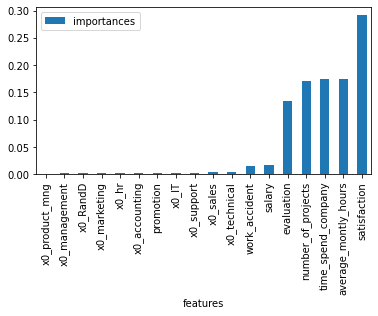

In [8]:
def plot_feature_importances(rf, cols, model_dir):
    importances = pd.DataFrame()
    importances.loc[:, 'importances'] = rf.feature_importances_
    importances.loc[:, 'features'] = cols
    importances.sort_values('importances', inplace=True)
    f, a = plt.subplots()
    importances.plot(ax=a, kind='bar', x='features', y='importances')
    plt.gcf().subplots_adjust(bottom=0.3)
    f.savefig(os.path.join(model_dir, 'importances.png'))

plot_feature_importances(rf, x_tr.columns, '.')

What samples are we getting wrong:

In [24]:
pred_te = pd.DataFrame(rf.predict(x_te), columns=['prediction'], index=x_te.index)

te = pd.concat([y_te, pred_te], axis=1)

te.loc[:, 'mistake'] = te['churn'] != te['prediction']

mistakes = te.loc[te['mistake'], :]
print(f'{mistakes.shape[0]} mistakes')

x_te.loc[mistakes.index, :].mean() - x_te.mean()

39 mistakes


satisfaction           -0.010942
evaluation              0.088379
number_of_projects      0.220000
average_montly_hours    3.285313
time_spend_company      0.306031
work_accident          -0.070810
promotion              -0.021867
salary                 -0.290174
x0_IT                  -0.082133
x0_RandD                0.045497
x0_accounting          -0.018359
x0_hr                   0.048697
x0_management           0.030790
x0_marketing            0.016656
x0_product_mng         -0.035159
x0_sales               -0.008656
x0_support              0.107610
x0_technical           -0.104944
dtype: float64

In [ ]:
x_